# Image Classification of ATLAS Calorimeter Topo-Clusters Rewrite

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import uproot as ur
path_prefix = '/AL/Phd/maxml/caloml-atlas/'
plotpath = path_prefix+'classifier/Plots/'
modelpath = path_prefix+'classifier/Models/'
# %config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

In [3]:
# import our resolution utilities

import sys
sys.path.append(path_prefix)
sys.path
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

In [4]:
# import pi+- vs. pi0 images

inputpath = path_prefix+'inputs/'
#path = '/eos/user/m/mswiatlo/images/'
branches = ['runNumber', 'eventNumber', 'truthE', 'truthPt', 'truthEta', 'truthPhi', 'clusterIndex', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_OOC_WEIGHT', 'cluster_DM_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cell_dR_min', 'cluster_cell_dR_max', 'cluster_cell_dEta_min', 'cluster_cell_dEta_max', 'cluster_cell_dPhi_min', 'cluster_cell_dPhi_max', 'cluster_cell_centerCellEta', 'cluster_cell_centerCellPhi', 'cluster_cell_centerCellLayer', 'cluster_cellE_norm']
rootfiles = ["pi0", "piplus", "piminus"]
trees = {
    rfile : ur.open(inputpath+rfile+".root")['ClusterTree']
    for rfile in rootfiles
}
pdata = {
    ifile : itree.pandas.df(branches, flatten=False)
    for ifile, itree in trees.items()
}

np0 = len(pdata['pi0'])
npp = len(pdata['piplus'])
npm = len(pdata['piminus'])

print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
print("Total: {}".format(np0+npp+npm))

Number of pi0 events: 263891
Number of pi+ events: 435967
Number of pi- events: 434627
Total: 1134485


Vectors in the root file have to be handled separately since pandas doesn't import them nicely

In [5]:
cell_shapes = {
    'EMB1': (128,4),
    'EMB2': (16,16),
    'EMB3': (8,16),
    'TileBar0': (4,4),
    'TileBar1': (4,4),
    'TileBar2': (2,4),
}

pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer)
        for layer in layers
    }
    for ifile, itree in trees.items()
}

### Plot a few example images

<Figure size 576x432 with 0 Axes>

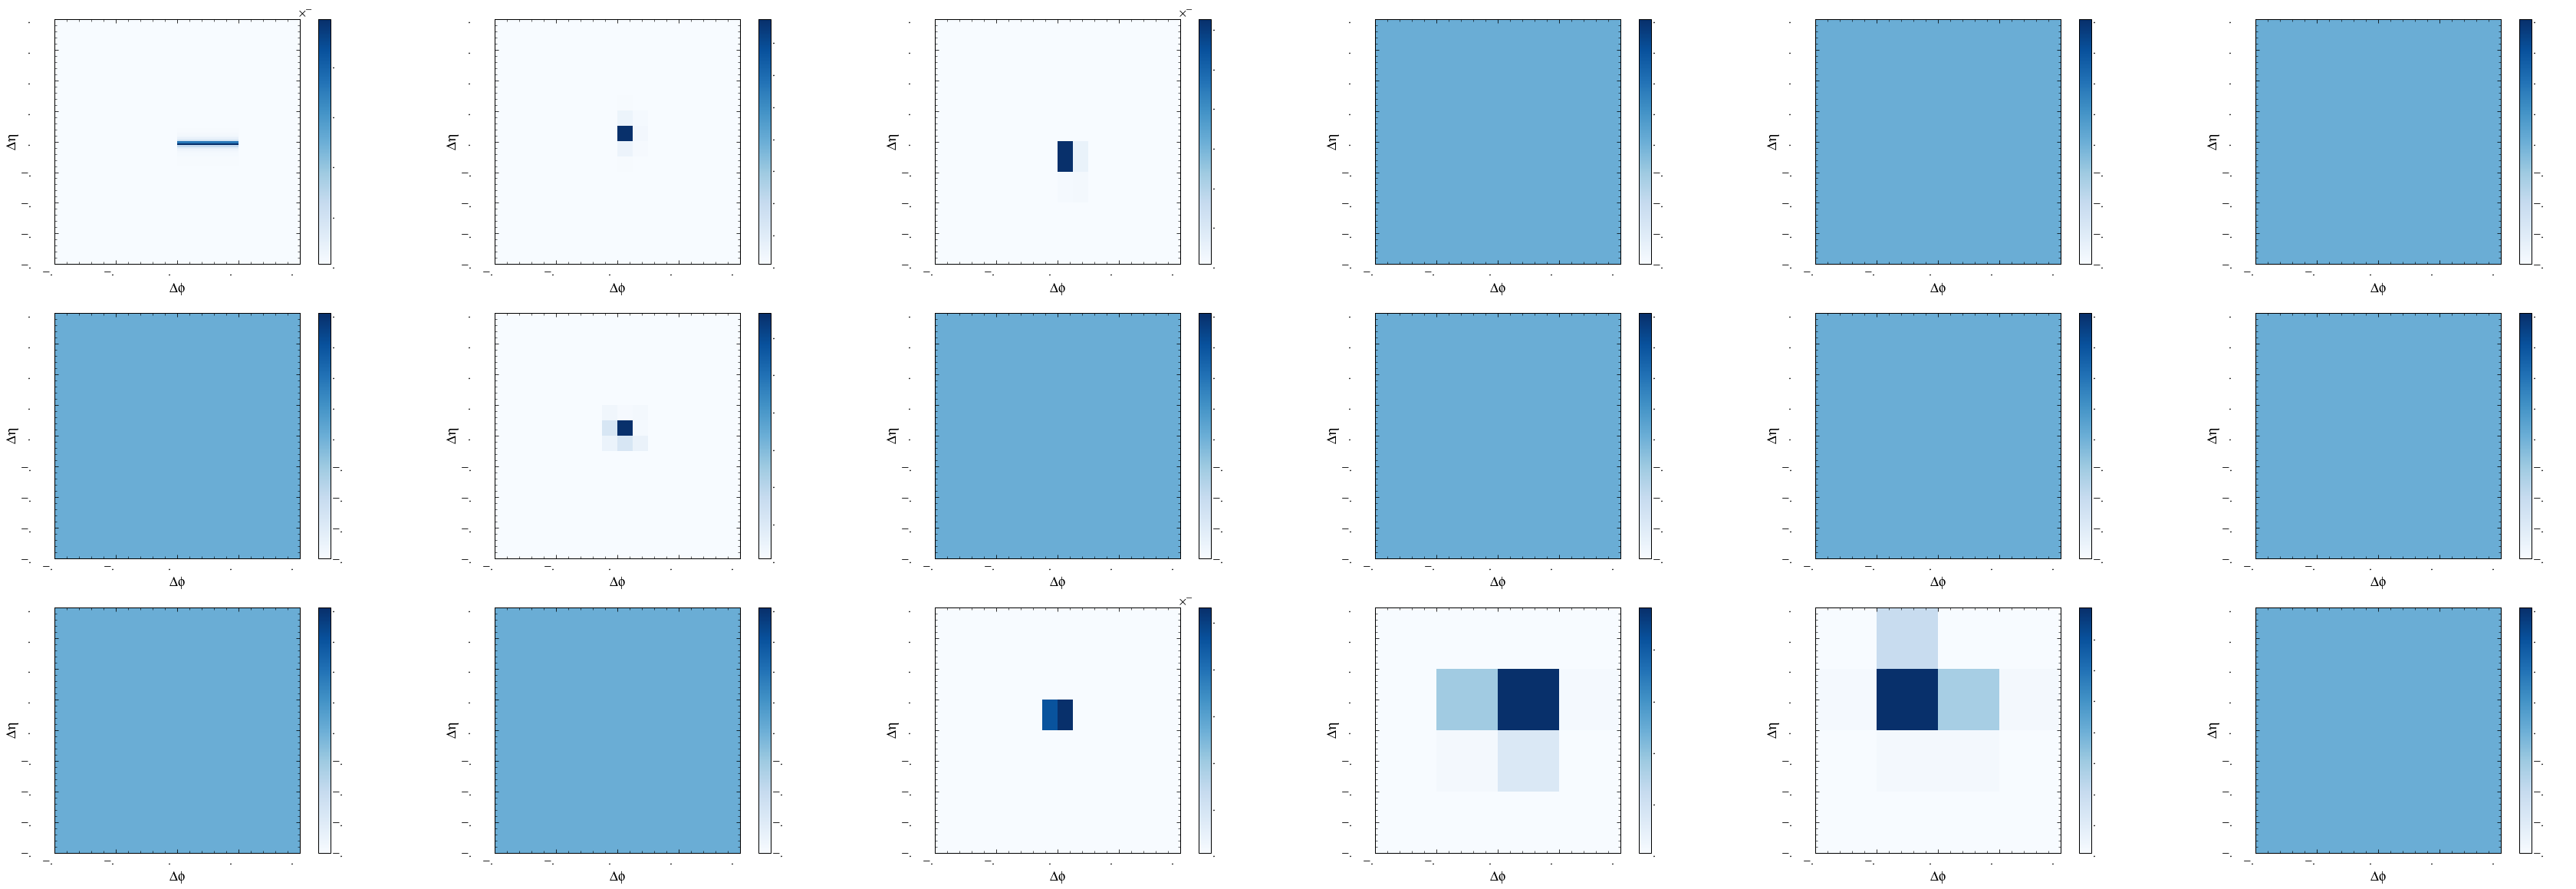

In [80]:
# plots for E = 0.5-2000 GeV pi0/pi+/pi- samples

from matplotlib.colors import Normalize, LogNorm

# specify which cluster to plot
cluster = 100

# make the plot
plt.cla(); plt.clf()
fig = plt.figure(figsize=(60,20))
fig.patch.set_facecolor('white')

i = 0
for ptype, pcell in pcells.items():
    for layer in layers:
        i = i+1
        plt.subplot(3,6,i)
        plt.imshow(pcell[layer][cluster].reshape(cell_shapes[layer]), extent=[-0.2, 0.2, -0.2, 0.2],
            cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
        plt.colorbar()
        plt.title(ptype+ 'in '+str(layer))
        plt.xlabel("$\Delta\phi$")
        plt.ylabel("$\Delta\eta$")

# show the plots
plt.savefig(plotpath+'plots_pi0_plus_minus.pdf')
plt.show()

### Plot a few histograms

<Figure size 576x432 with 0 Axes>

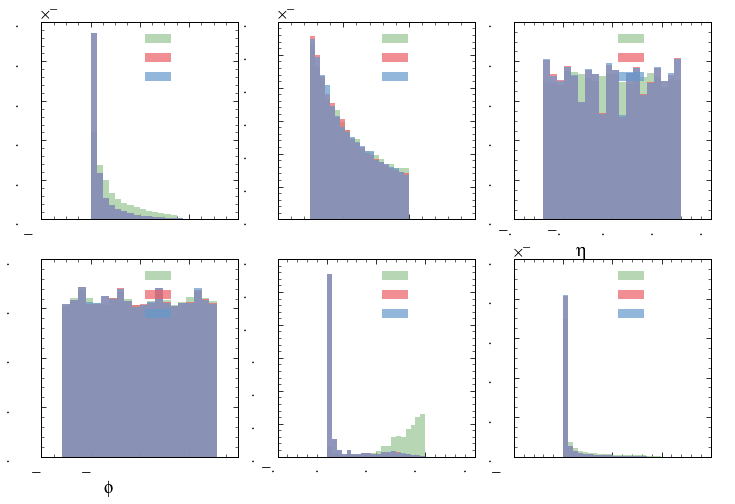

<Figure size 576x432 with 0 Axes>

In [81]:
# histograms for E = 0.5-2000 GeV pi0/pi+/pi- samples

n_bins=20

plt.cla(); plt.clf()
fig = plt.figure(figsize=(12,8))
fig.patch.set_facecolor('white')

qtys = ['cluster_nCells', 'clusterE', 'clusterEta', 'clusterPhi', 'cluster_EM_PROBABILITY', 'cluster_sumCellE']
qty_labels = ['Cells/Cluster', 'Cluster Energy [GeV]', 'Cluster $\eta$', 'Cluster $\phi$', 'Cluster EMProb', 'Cluster SumCellE']
qty_ranges = [(0,500), (50,200), None, None, None, None]
for i, (qty, label, rng) in enumerate(zip(qtys, qty_labels, qty_ranges)):
    plt.subplot(2,3,i+1)
    for ptype, p in pdata.items():
        plt.hist(p[qty], bins=n_bins, density=True,
                 range=rng, alpha=0.7, label=ptype)
    plt.xlabel(label)
    plt.legend()

plt.show()
plt.savefig(plotpath+'hist_pi0_plus_minus.png')

## 1. Simple feed-forward Neural Network

In [38]:
import tensorflow as tf

gpu_list = ["/gpu:0"] #["/gpu:0","/gpu:1","/gpu:2","/gpu:3"]
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [20]:
from keras.utils import np_utils
training_dataset = ['pi0','piplus']

# create train/validation/test subsets containing 70%/10%/20%
# of events from each type of pion event
for p_index, plabel in enumerate(training_dataset):
    mu.splitFrameTVT(pdata[plabel],trainfrac=0.7)
    pdata[plabel]['label'] = p_index

# merge pi0 and pi+ events
pdata_merged = pd.concat([pdata[ptype] for ptype in training_dataset])
pcells_merged = {
    layer : np.concatenate([pcells[ptype][layer]
                            for ptype in training_dataset])
    for layer in layers
}
plabels = np_utils.to_categorical(pdata_merged['label'],len(training_dataset))


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [32]:
# define baseline fully-connected NN model
def baseline_nn_model(number_pixels):
    # create model
    with strategy.scope():    
        model = Sequential()
        used_pixels = number_pixels
#     if number_pixels < 128:
#         used_pixels = 128
        model.add(Dense(number_pixels, input_dim=number_pixels, kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(used_pixels, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(int(used_pixels/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
        # compile model
        optimizer = Adam(lr=5e-5)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
    return model

In [39]:
# build the model
models = {}
for layer in layers:
    npix = cell_shapes[layer][0]*cell_shapes[layer][1]
    models[layer] = baseline_nn_model(npix)
    models[layer].summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)

In [71]:
temp_test = models['EMB1'].predict(pcells_merged['EMB1'])

In [75]:
type(temp_test)
temp_test.shape
temp_test[0][0]+temp_test[0][1]

1.0

In [76]:
model_history = {}
model_performance = {}
model_scores = {}
for layer in layers:
    print('On layer ' + layer)
    
    # train+validate model
    model_history[layer] = models[layer].fit(
        pcells_merged[layer][pdata_merged.train], plabels[pdata_merged.train],
        validation_data = (
            pcells_merged[layer][pdata_merged.val], plabels[pdata_merged.val]
        ),
        epochs = 100, batch_size = 200*ngpu, verbose = 2,
    )
    model_history[layer] = model_history[layer].history
    # get overall performance metric
    model_performance[layer] = models[layer].evaluate(
        pcells_merged[layer][pdata_merged.test], plabels[pdata_merged.test],
        verbose = 0,
    )
    
    # get network scores for the dataset
    model_scores[layer] = models[layer].predict(
        pcells_merged[layer]
    )
    
    print('Finished layer ' + layer)
    

On layer EMB1
Train on 489899 samples, validate on 69988 samples
Epoch 1/100
489899/489899 - 9s - loss: 0.2394 - acc: 0.9103 - val_loss: 0.2412 - val_acc: 0.9089
Epoch 2/100
489899/489899 - 8s - loss: 0.2379 - acc: 0.9105 - val_loss: 0.2406 - val_acc: 0.9094
Epoch 3/100
489899/489899 - 8s - loss: 0.2366 - acc: 0.9114 - val_loss: 0.2364 - val_acc: 0.9113
Epoch 4/100
489899/489899 - 8s - loss: 0.2356 - acc: 0.9116 - val_loss: 0.2350 - val_acc: 0.9119
Epoch 5/100
489899/489899 - 7s - loss: 0.2345 - acc: 0.9117 - val_loss: 0.2366 - val_acc: 0.9104
Epoch 6/100
489899/489899 - 7s - loss: 0.2337 - acc: 0.9125 - val_loss: 0.2341 - val_acc: 0.9124
Epoch 7/100
489899/489899 - 8s - loss: 0.2332 - acc: 0.9126 - val_loss: 0.2355 - val_acc: 0.9115
Epoch 8/100
489899/489899 - 8s - loss: 0.2326 - acc: 0.9129 - val_loss: 0.2325 - val_acc: 0.9127
Epoch 9/100
489899/489899 - 8s - loss: 0.2317 - acc: 0.9132 - val_loss: 0.2325 - val_acc: 0.9131
Epoch 10/100
489899/489899 - 8s - loss: 0.2314 - acc: 0.9135 -

489899/489899 - 7s - loss: 0.2114 - acc: 0.9218 - val_loss: 0.2152 - val_acc: 0.9223
Epoch 85/100
489899/489899 - 7s - loss: 0.2112 - acc: 0.9221 - val_loss: 0.2179 - val_acc: 0.9204
Epoch 86/100
489899/489899 - 7s - loss: 0.2110 - acc: 0.9220 - val_loss: 0.2168 - val_acc: 0.9210
Epoch 87/100
489899/489899 - 7s - loss: 0.2106 - acc: 0.9222 - val_loss: 0.2151 - val_acc: 0.9214
Epoch 88/100
489899/489899 - 7s - loss: 0.2105 - acc: 0.9224 - val_loss: 0.2187 - val_acc: 0.9201
Epoch 89/100
489899/489899 - 8s - loss: 0.2107 - acc: 0.9222 - val_loss: 0.2154 - val_acc: 0.9212
Epoch 90/100
489899/489899 - 8s - loss: 0.2105 - acc: 0.9222 - val_loss: 0.2151 - val_acc: 0.9219
Epoch 91/100
489899/489899 - 7s - loss: 0.2101 - acc: 0.9220 - val_loss: 0.2156 - val_acc: 0.9220
Epoch 92/100
489899/489899 - 7s - loss: 0.2101 - acc: 0.9222 - val_loss: 0.2152 - val_acc: 0.9213
Epoch 93/100
489899/489899 - 7s - loss: 0.2098 - acc: 0.9228 - val_loss: 0.2161 - val_acc: 0.9214
Epoch 94/100
489899/489899 - 8s -

Epoch 67/100
489899/489899 - 6s - loss: 0.2373 - acc: 0.9038 - val_loss: 0.2297 - val_acc: 0.9089
Epoch 68/100
489899/489899 - 6s - loss: 0.2371 - acc: 0.9044 - val_loss: 0.2301 - val_acc: 0.9085
Epoch 69/100
489899/489899 - 6s - loss: 0.2370 - acc: 0.9044 - val_loss: 0.2297 - val_acc: 0.9085
Epoch 70/100
489899/489899 - 6s - loss: 0.2362 - acc: 0.9044 - val_loss: 0.2313 - val_acc: 0.9061
Epoch 71/100
489899/489899 - 6s - loss: 0.2363 - acc: 0.9046 - val_loss: 0.2302 - val_acc: 0.9085
Epoch 72/100
489899/489899 - 6s - loss: 0.2359 - acc: 0.9048 - val_loss: 0.2308 - val_acc: 0.9073
Epoch 73/100
489899/489899 - 6s - loss: 0.2361 - acc: 0.9047 - val_loss: 0.2300 - val_acc: 0.9076
Epoch 74/100
489899/489899 - 6s - loss: 0.2354 - acc: 0.9048 - val_loss: 0.2275 - val_acc: 0.9090
Epoch 75/100
489899/489899 - 6s - loss: 0.2351 - acc: 0.9054 - val_loss: 0.2294 - val_acc: 0.9085
Epoch 76/100
489899/489899 - 6s - loss: 0.2347 - acc: 0.9054 - val_loss: 0.2273 - val_acc: 0.9096
Epoch 77/100
489899/

Epoch 50/100
489899/489899 - 7s - loss: 0.4218 - acc: 0.8087 - val_loss: 0.4123 - val_acc: 0.8144
Epoch 51/100
489899/489899 - 6s - loss: 0.4210 - acc: 0.8095 - val_loss: 0.4115 - val_acc: 0.8118
Epoch 52/100
489899/489899 - 7s - loss: 0.4204 - acc: 0.8095 - val_loss: 0.4114 - val_acc: 0.8143
Epoch 53/100
489899/489899 - 6s - loss: 0.4206 - acc: 0.8093 - val_loss: 0.4128 - val_acc: 0.8097
Epoch 54/100
489899/489899 - 6s - loss: 0.4203 - acc: 0.8093 - val_loss: 0.4135 - val_acc: 0.8113
Epoch 55/100
489899/489899 - 7s - loss: 0.4196 - acc: 0.8095 - val_loss: 0.4153 - val_acc: 0.8090
Epoch 56/100
489899/489899 - 7s - loss: 0.4193 - acc: 0.8099 - val_loss: 0.4118 - val_acc: 0.8134
Epoch 57/100
489899/489899 - 7s - loss: 0.4193 - acc: 0.8098 - val_loss: 0.4139 - val_acc: 0.8094
Epoch 58/100
489899/489899 - 6s - loss: 0.4189 - acc: 0.8098 - val_loss: 0.4146 - val_acc: 0.8087
Epoch 59/100
489899/489899 - 6s - loss: 0.4182 - acc: 0.8098 - val_loss: 0.4082 - val_acc: 0.8150
Epoch 60/100
489899/

Epoch 33/100
489899/489899 - 6s - loss: 0.5541 - acc: 0.6506 - val_loss: 0.5450 - val_acc: 0.6563
Epoch 34/100
489899/489899 - 6s - loss: 0.5541 - acc: 0.6504 - val_loss: 0.5447 - val_acc: 0.6548
Epoch 35/100
489899/489899 - 6s - loss: 0.5546 - acc: 0.6507 - val_loss: 0.5447 - val_acc: 0.6554
Epoch 36/100
489899/489899 - 6s - loss: 0.5540 - acc: 0.6501 - val_loss: 0.5446 - val_acc: 0.6560
Epoch 37/100
489899/489899 - 6s - loss: 0.5537 - acc: 0.6503 - val_loss: 0.5445 - val_acc: 0.6567
Epoch 38/100
489899/489899 - 6s - loss: 0.5540 - acc: 0.6503 - val_loss: 0.5442 - val_acc: 0.6560
Epoch 39/100
489899/489899 - 6s - loss: 0.5536 - acc: 0.6503 - val_loss: 0.5439 - val_acc: 0.6552
Epoch 40/100
489899/489899 - 6s - loss: 0.5538 - acc: 0.6500 - val_loss: 0.5439 - val_acc: 0.6566
Epoch 41/100
489899/489899 - 6s - loss: 0.5540 - acc: 0.6500 - val_loss: 0.5437 - val_acc: 0.6562
Epoch 42/100
489899/489899 - 6s - loss: 0.5540 - acc: 0.6497 - val_loss: 0.5437 - val_acc: 0.6562
Epoch 43/100
489899/

Epoch 16/100
489899/489899 - 6s - loss: 0.5312 - acc: 0.6495 - val_loss: 0.5292 - val_acc: 0.6585
Epoch 17/100
489899/489899 - 7s - loss: 0.5309 - acc: 0.6496 - val_loss: 0.5287 - val_acc: 0.6576
Epoch 18/100
489899/489899 - 6s - loss: 0.5307 - acc: 0.6500 - val_loss: 0.5282 - val_acc: 0.6229
Epoch 19/100
489899/489899 - 6s - loss: 0.5299 - acc: 0.6501 - val_loss: 0.5279 - val_acc: 0.6540
Epoch 20/100
489899/489899 - 6s - loss: 0.5296 - acc: 0.6497 - val_loss: 0.5271 - val_acc: 0.6582
Epoch 21/100
489899/489899 - 6s - loss: 0.5293 - acc: 0.6498 - val_loss: 0.5267 - val_acc: 0.6586
Epoch 22/100
489899/489899 - 7s - loss: 0.5297 - acc: 0.6498 - val_loss: 0.5264 - val_acc: 0.6580
Epoch 23/100
489899/489899 - 7s - loss: 0.5296 - acc: 0.6496 - val_loss: 0.5262 - val_acc: 0.6584
Epoch 24/100
489899/489899 - 8s - loss: 0.5288 - acc: 0.6495 - val_loss: 0.5260 - val_acc: 0.6583
Epoch 25/100
489899/489899 - 11s - loss: 0.5290 - acc: 0.6496 - val_loss: 0.5259 - val_acc: 0.6578
Epoch 26/100
489899

Epoch 100/100
489899/489899 - 8s - loss: 0.5239 - acc: 0.6497 - val_loss: 0.5185 - val_acc: 0.6588
Finished layer TileBar1
On layer TileBar2
Train on 489899 samples, validate on 69988 samples
Epoch 1/100
489899/489899 - 9s - loss: 0.6627 - acc: 0.6229 - val_loss: 0.6594 - val_acc: 0.6229
Epoch 2/100
489899/489899 - 8s - loss: 0.6598 - acc: 0.6229 - val_loss: 0.6564 - val_acc: 0.6229
Epoch 3/100
489899/489899 - 8s - loss: 0.6554 - acc: 0.6229 - val_loss: 0.6507 - val_acc: 0.6229
Epoch 4/100
489899/489899 - 8s - loss: 0.6491 - acc: 0.6229 - val_loss: 0.6440 - val_acc: 0.6229
Epoch 5/100
489899/489899 - 8s - loss: 0.6426 - acc: 0.6229 - val_loss: 0.6379 - val_acc: 0.6229
Epoch 6/100
489899/489899 - 8s - loss: 0.6365 - acc: 0.6229 - val_loss: 0.6324 - val_acc: 0.6229
Epoch 7/100
489899/489899 - 8s - loss: 0.6314 - acc: 0.6229 - val_loss: 0.6280 - val_acc: 0.6229
Epoch 8/100
489899/489899 - 8s - loss: 0.6279 - acc: 0.6229 - val_loss: 0.6248 - val_acc: 0.6229
Epoch 9/100
489899/489899 - 8s -

Epoch 83/100
489899/489899 - 6s - loss: 0.5990 - acc: 0.6229 - val_loss: 0.5962 - val_acc: 0.6229
Epoch 84/100
489899/489899 - 8s - loss: 0.5988 - acc: 0.6229 - val_loss: 0.5960 - val_acc: 0.6229
Epoch 85/100
489899/489899 - 7s - loss: 0.5986 - acc: 0.6229 - val_loss: 0.5958 - val_acc: 0.6229
Epoch 86/100
489899/489899 - 8s - loss: 0.5996 - acc: 0.6229 - val_loss: 0.5960 - val_acc: 0.6229
Epoch 87/100
489899/489899 - 7s - loss: 0.5988 - acc: 0.6229 - val_loss: 0.5958 - val_acc: 0.6229
Epoch 88/100
489899/489899 - 6s - loss: 0.5985 - acc: 0.6229 - val_loss: 0.5957 - val_acc: 0.6229
Epoch 89/100
489899/489899 - 6s - loss: 0.5992 - acc: 0.6229 - val_loss: 0.5960 - val_acc: 0.6229
Epoch 90/100
489899/489899 - 6s - loss: 0.5995 - acc: 0.6229 - val_loss: 0.5957 - val_acc: 0.6229
Epoch 91/100
489899/489899 - 6s - loss: 0.5980 - acc: 0.6229 - val_loss: 0.5957 - val_acc: 0.6229
Epoch 92/100
489899/489899 - 6s - loss: 0.5984 - acc: 0.6229 - val_loss: 0.5956 - val_acc: 0.6229
Epoch 93/100
489899/

In [100]:
import pickle

for layer in layers:
    print('Saving ' + layer)
    models[layer].save(modelpath+'model_' + layer + '_flat_do20.h5')
    
    with open(modelpath + 'model_' + layer + '_flat_do20.history','wb') as model_history_file:
        pickle.dump(model_history[layer], model_history_file)

Saving EMB1
Saving EMB2
Saving EMB3
Saving TileBar0
Saving TileBar1
Saving TileBar2


In [5]:
import pickle

#alternate to fitting the model: load a saved model
models = {}
model_history = {}
model_scores = {}
for layer in layers:
    print('Loading ' + layer)
    models[layer] = tf.keras.models.load_model(modelpath+'model_' + layer + '_flat_do20.h5')
    
    # load history object
    with open(modelpath + 'model_' + layer + '_flat_do20.history','rb') as model_history_file:
        model_history[layer] = pickle.load(model_history_file)
    
    # recalculate network scores for the dataset
    model_scores[layer] = models[layer].predict(
        pcells_merged[layer]
    )

Loading EMB1
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Loading EMB2
Loading EMB3
Loading TileBar0
Loading TileBar1
Loading TileBar2


<Figure size 576x432 with 0 Axes>

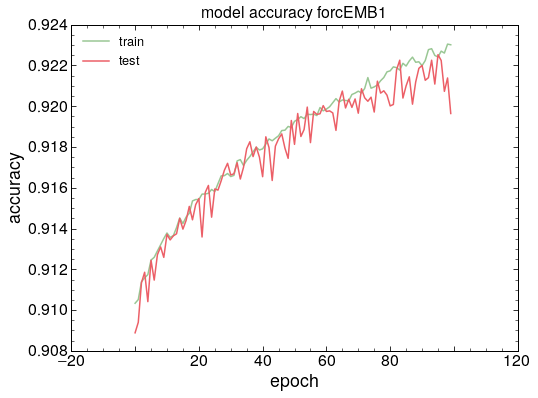

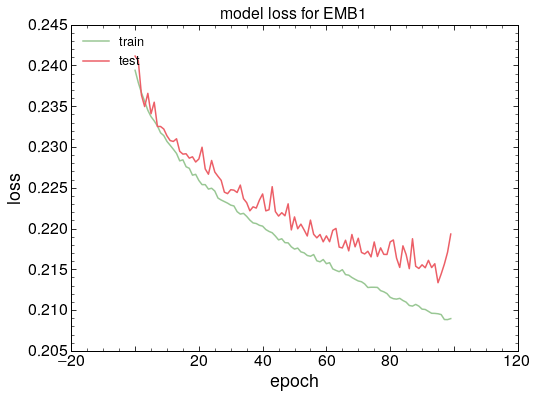

<Figure size 576x432 with 0 Axes>

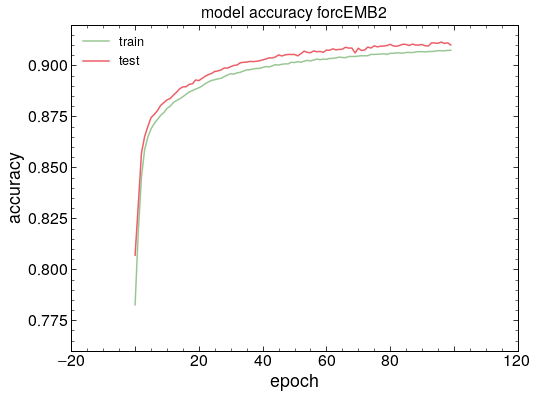

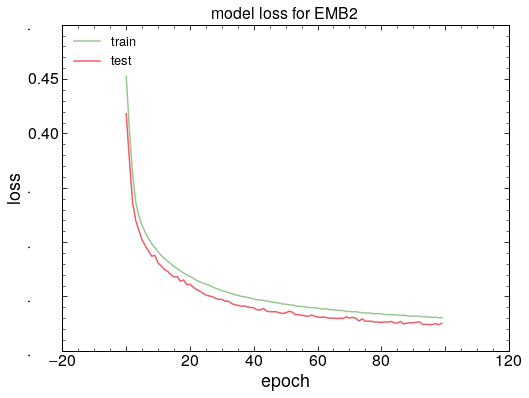

<Figure size 576x432 with 0 Axes>

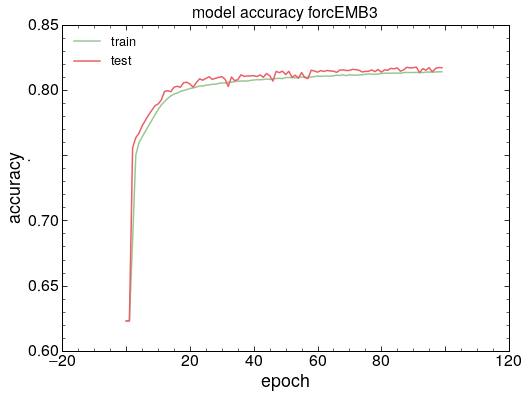

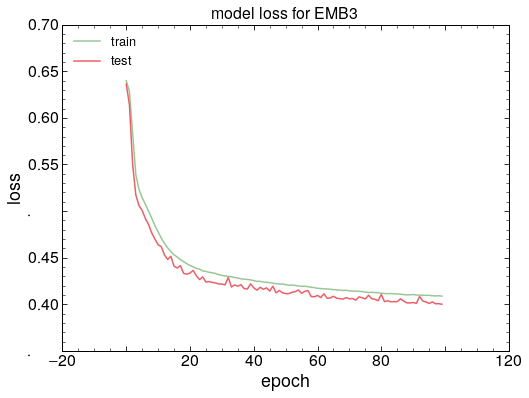

<Figure size 576x432 with 0 Axes>

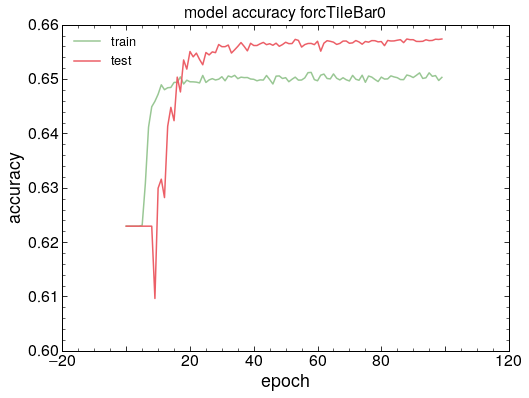

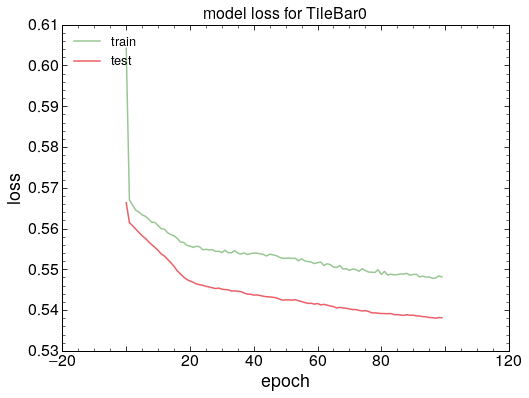

<Figure size 576x432 with 0 Axes>

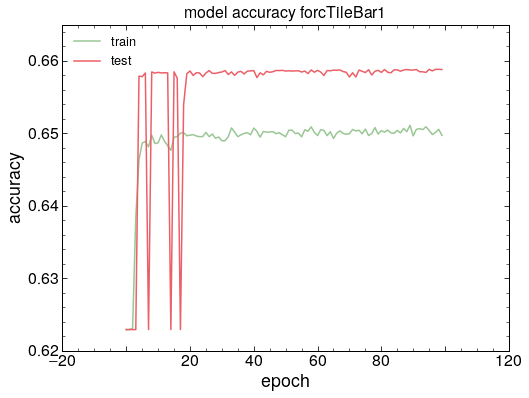

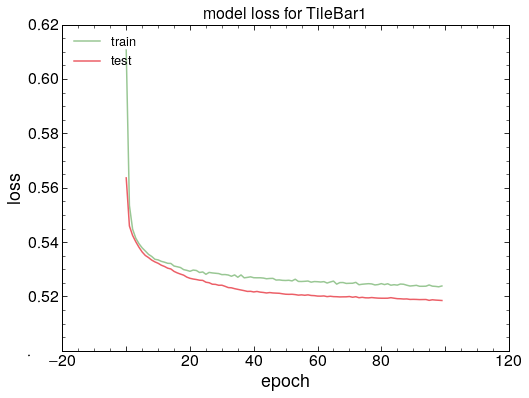

<Figure size 576x432 with 0 Axes>

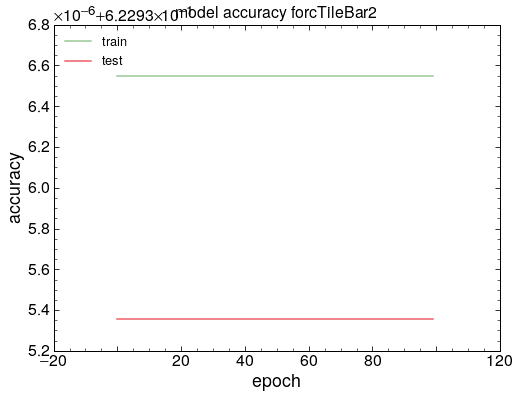

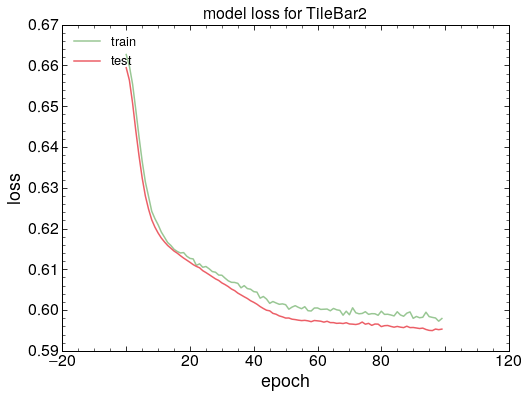

In [79]:
for layer in layers:
#     print(history_flat[layer_i].history.keys())
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(model_history[layer]['acc'])
    plt.plot(model_history[layer]['val_acc'])
    plt.title('model accuracy for ' + layer)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/accuracy_' + layer + '.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(model_history[layer]['loss'])
    plt.plot(model_history[layer]['val_loss'])
    plt.title('model loss for ' + layer)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/loss_' + layer + '.pdf')
    plt.show()

In [91]:
from sklearn.metrics import roc_curve, auc

roc_fpr = {}
roc_tpr = {}
roc_thresh = {}
roc_auc = {}

for layer in layers:
    roc_fpr[layer], roc_tpr[layer], roc_thresh[layer] = roc_curve(
        plabels[pdata_merged.test][:,1],
        model_scores[layer][pdata_merged.test,1],
        drop_intermediate=False,
    )
    roc_auc[layer] = auc(roc_fpr[layer], roc_tpr[layer])
    print('Area under curve for ' + layer + ': ' + str(roc_auc[layer]))

Area under curve for EMB1: 0.9686889414398973
Area under curve for EMB2: 0.9651876802225479
Area under curve for EMB3: 0.8658701369042857
Area under curve for TileBar0: 0.7711980818318057
Area under curve for TileBar1: 0.718738001364303
Area under curve for TileBar2: 0.6402433282374058


In [13]:
x_lc = np.append(1-p0['cluster_EM_PROBABILITY'],1 - pp['cluster_EM_PROBABILITY'])
y_lc = np.append(p0['label'], pp['label']) 

In [14]:
fpr_lc, tpr_lc, thresh_lc = roc_curve(y_lc, x_lc)
auc_lc = auc(fpr_lc, tpr_lc)
print("Area under curve: {}".format(auc_lc))

Area under curve: 0.950805032076483


<Figure size 432x288 with 0 Axes>

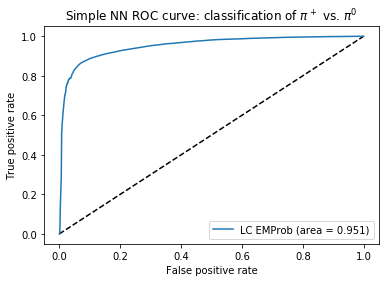

In [15]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_lc_only.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

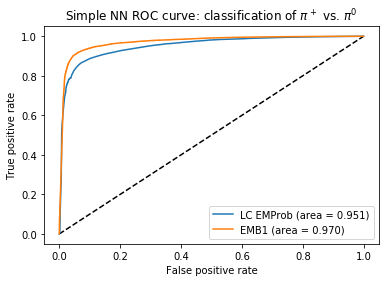

In [16]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.plot(fpr_flat_nn[0], tpr_flat_nn[0], label='{} (area = {:.3f})'.format('EMB1', auc_flat_nn[0]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_lc_emb1_only.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

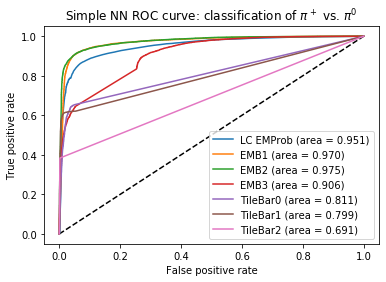

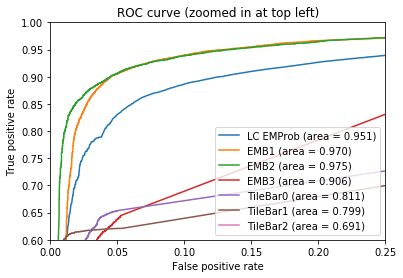

In [22]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_layers.pdf')
plt.show()


# Zoom in view of the upper left corner.
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_layers.pdf')
plt.show()


In [17]:
y_flat_pred_stack = np.column_stack((y_flat_pred[0][:,1], y_flat_pred[1][:,1],y_flat_pred[2][:,1],y_flat_pred[3][:,1],y_flat_pred[4][:,1],y_flat_pred[5][:,1]))

y_flat_pred_vl = {}
for layer_i, layer_name in enumerate(layers):
    y_flat_pred_vl[layer_i] = models_flat[layer_i].predict(x_flat_vl[layer_i])
#     print len(y_flat_pred_vl[layer_i])

y_flat_pred_vl_stack = np.column_stack((y_flat_pred_vl[0][:,1], y_flat_pred_vl[1][:,1],y_flat_pred_vl[2][:,1],y_flat_pred_vl[3][:,1],y_flat_pred_vl[4][:,1],y_flat_pred_vl[5][:,1]))

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

model_simpleCombine = Sequential()
model_simpleCombine.add(Dense(6, input_dim=6, kernel_initializer='normal', activation='relu'))
model_simpleCombine.add(Dense(4, activation='relu'))
model_simpleCombine.add(Dense(2, kernel_initializer='normal', activation='softmax'))
model_simpleCombine.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc'])
history_simpleCombine = model_simpleCombine.fit(y_flat_pred_stack, y_flat_te_onehot[0], epochs = 200, batch_size = 200*ngpu, verbose = 2)

Epoch 1/200
24000/24000 - 0s - loss: 0.6874 - acc: 0.5552
Epoch 2/200
24000/24000 - 0s - loss: 0.6611 - acc: 0.5552
Epoch 3/200
24000/24000 - 0s - loss: 0.6142 - acc: 0.5552
Epoch 4/200
24000/24000 - 0s - loss: 0.5403 - acc: 0.6576
Epoch 5/200
24000/24000 - 0s - loss: 0.4577 - acc: 0.8281
Epoch 6/200
24000/24000 - 0s - loss: 0.3835 - acc: 0.9117
Epoch 7/200
24000/24000 - 0s - loss: 0.3252 - acc: 0.9325
Epoch 8/200
24000/24000 - 0s - loss: 0.2795 - acc: 0.9400
Epoch 9/200
24000/24000 - 0s - loss: 0.2442 - acc: 0.9440
Epoch 10/200
24000/24000 - 0s - loss: 0.2174 - acc: 0.9451
Epoch 11/200
24000/24000 - 0s - loss: 0.1975 - acc: 0.9458
Epoch 12/200
24000/24000 - 0s - loss: 0.1836 - acc: 0.9469
Epoch 13/200
24000/24000 - 0s - loss: 0.1738 - acc: 0.9472
Epoch 14/200
24000/24000 - 0s - loss: 0.1673 - acc: 0.9478
Epoch 15/200
24000/24000 - 0s - loss: 0.1630 - acc: 0.9477
Epoch 16/200
24000/24000 - 0s - loss: 0.1599 - acc: 0.9483
Epoch 17/200
24000/24000 - 0s - loss: 0.1579 - acc: 0.9482
Epoch 

Epoch 140/200
24000/24000 - 0s - loss: 0.1489 - acc: 0.9489
Epoch 141/200
24000/24000 - 0s - loss: 0.1489 - acc: 0.9491
Epoch 142/200
24000/24000 - 0s - loss: 0.1488 - acc: 0.9492
Epoch 143/200
24000/24000 - 0s - loss: 0.1489 - acc: 0.9497
Epoch 144/200
24000/24000 - 0s - loss: 0.1489 - acc: 0.9490
Epoch 145/200
24000/24000 - 0s - loss: 0.1489 - acc: 0.9492
Epoch 146/200
24000/24000 - 0s - loss: 0.1488 - acc: 0.9490
Epoch 147/200
24000/24000 - 0s - loss: 0.1489 - acc: 0.9492
Epoch 148/200
24000/24000 - 0s - loss: 0.1489 - acc: 0.9495
Epoch 149/200
24000/24000 - 0s - loss: 0.1490 - acc: 0.9491
Epoch 150/200
24000/24000 - 0s - loss: 0.1490 - acc: 0.9492
Epoch 151/200
24000/24000 - 0s - loss: 0.1489 - acc: 0.9496
Epoch 152/200
24000/24000 - 0s - loss: 0.1489 - acc: 0.9492
Epoch 153/200
24000/24000 - 0s - loss: 0.1488 - acc: 0.9494
Epoch 154/200
24000/24000 - 0s - loss: 0.1488 - acc: 0.9492
Epoch 155/200
24000/24000 - 0s - loss: 0.1488 - acc: 0.9495
Epoch 156/200
24000/24000 - 0s - loss: 0

<Figure size 432x288 with 0 Axes>

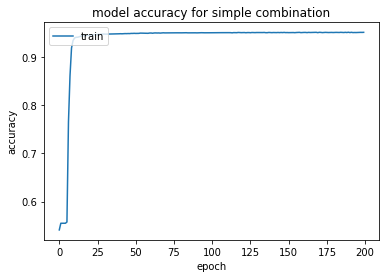

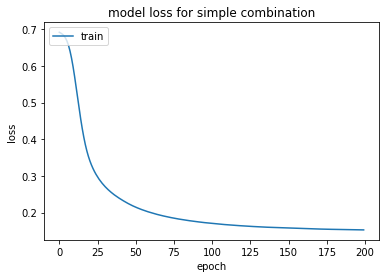

In [25]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_simpleCombine.history['acc'])
#     plt.plot(history_simpleCombine.history['val_acc'])
    plt.title('model accuracy for simple combination')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(plotpath+'accuracy_simpleCombine.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_simpleCombine.history['loss'])
#     plt.plot(history_simpleCombine.history['val_loss'])
    plt.title('model loss for simple combination')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(plotpath+'loss_simpleCombine.pdf')
    plt.show()
    

In [19]:
combined_pred = model_simpleCombine.predict(y_flat_pred_vl_stack)
fpr_simpleCombine, tpr_simpleCombine, thres_simpleCombine = roc_curve(y_flat_vl_onehot[layer_i][:,1], combined_pred[:,1])
auc_combined  = auc(fpr_simpleCombine, tpr_simpleCombine)
print(auc_combined)

0.9817484453978564


<Figure size 432x288 with 0 Axes>

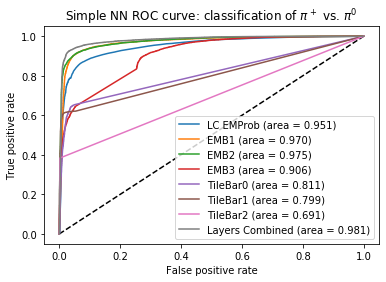

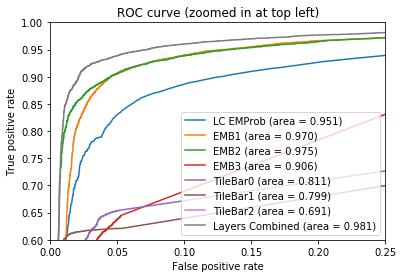

In [28]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers Combined", auc_combined))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig(plotpath+'roc_combine1_layers.pdf')
plt.show()


# Zoom in view of the upper left corner.
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers Combined", auc_combined))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig(plotpath+'roc_zoom_combine1_layers.pdf')
plt.show()


In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

In [30]:
with strategy.scope():    

    model_combine = Sequential()

    #EMB1
    input1 = Input(shape=(512,), name = 'input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dropout(0.2)(x1)
    x1 = Dense(256, activation='relu')(x1)
    x1 = Dropout(0.2)(x1)
    x1 = Dense(128, activation='relu')(x1)
    x1 = Dropout(0.2)(x1)

    #EMB2
    input2 = Input(shape=(256,), name = 'input2')
    x2 = Dense(256, activation='relu')(input2)
    x2 = Dropout(0.2)(x2)
    x2 = Dense(128, activation='relu')(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Dense(64, activation='relu')(x2)
    x2 = Dropout(0.2)(x2)

    #EMB3
    input3 = Input(shape=(128,), name = 'input3')
    x3 = Dense(128, activation='relu')(input3)
    x3 = Dropout(0.2)(x3)
    x3 = Dense(64, activation='relu')(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Dense(32, activation='relu')(x3)
    x3 = Dropout(0.2)(x3)

    #Tile0
    input4 = Input(shape=(16,), name = 'input4')
    x4 = Dense(16, activation='relu')(input4)
    x4 = Dropout(0.2)(x4)
    x4 = Dense(8, activation='relu')(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Dense(4, activation='relu')(x4)
    x4 = Dropout(0.2)(x4)

    #Tile1
    input5 = Input(shape=(16,), name = 'input5')
    x5 = Dense(16, activation='relu')(input5)
    x5 = Dropout(0.2)(x5)
    x5 = Dense(8, activation='relu')(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Dense(4, activation='relu')(x5)
    x5 = Dropout(0.2)(x5)

    #Tile2
    input6 = Input(shape=(8,), name = 'input6')
    x6 = Dense(8, activation='relu')(input6)
    x6 = Dropout(0.2)(x6)
    x6 = Dense(4, activation='relu')(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Dense(2, activation='relu')(x6)
    x6 = Dropout(0.2)(x6)

    #Combination
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.2)(x)

    output_combine = Dense(2, activation='softmax')(x)

    model_combine = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output_combine])
    model_combine.compile(loss='categorical_crossentropy', optimizer=Adam(lr=5e-5), metrics=['acc'])   

In [31]:
history_combine = model_combine.fit([x_flat_tr[0], x_flat_tr[1], x_flat_tr[2], x_flat_tr[3], x_flat_tr[4], x_flat_tr[5]], [y_flat_tr_onehot[0]], validation_data=([x_flat_vl[0], x_flat_vl[1], x_flat_vl[2], x_flat_vl[3], x_flat_vl[4], x_flat_vl[5]], [y_flat_vl_onehot[0]]), epochs=200, batch_size=200*ngpu, verbose=2)

INFO:tensorflow:batch_all_reduce: 42 all-reduces with algorithm = nccl,num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
Epoch 1/200
291/291 - 40s - loss: 0.5263 - acc: 0.8001 - val_loss: 0.3220 - val_acc: 0.8852
Epoch 2/200
291/291 - 13s - loss: 0.3178 - acc: 0.8873 - val_loss: 0.2884 - val_acc: 0.8991
Epoch 3/200
291/291 - 13s - loss: 0.2960 - acc: 0.8965 - val_loss: 0.2738 - val_acc: 0.9038
Epoch 4/200
291/291 - 13s - loss: 0.2823 - acc: 0.9003 - val_loss: 0.2604 - val_acc: 0.9056
Epoch 5/200
291/291 - 13s - loss: 0.2664 - acc: 0.9022 - val_loss: 0.2454 - val_acc: 0.9073
Epoch 6/200
291/291 - 13s - loss: 0.2525 - acc: 0.9053 - val_loss: 0.2359 - val_acc: 0.9144
Epoch 7/200
291/291 - 13s - loss: 0.2450 - acc: 0.9109 - val_loss: 0.2325 - val_acc: 0.9168
Epoch 8/200
291/291 - 13s - loss: 0.2397 - acc: 0.9147 - val_loss: 0.2273 - val_acc: 0.9197
Epoch 9/200
291/291 - 13s - loss: 0.2349 - acc: 0.9172 - val_loss: 0.2246 - val_acc: 0.9213
Epoch 10/200
291/291 

Epoch 88/200
291/291 - 13s - loss: 0.1458 - acc: 0.9508 - val_loss: 0.1524 - val_acc: 0.9482
Epoch 89/200
291/291 - 13s - loss: 0.1458 - acc: 0.9507 - val_loss: 0.1523 - val_acc: 0.9477
Epoch 90/200
291/291 - 13s - loss: 0.1452 - acc: 0.9511 - val_loss: 0.1537 - val_acc: 0.9476
Epoch 91/200
291/291 - 13s - loss: 0.1449 - acc: 0.9512 - val_loss: 0.1528 - val_acc: 0.9481
Epoch 92/200
291/291 - 13s - loss: 0.1445 - acc: 0.9515 - val_loss: 0.1520 - val_acc: 0.9475
Epoch 93/200
291/291 - 13s - loss: 0.1444 - acc: 0.9512 - val_loss: 0.1515 - val_acc: 0.9488
Epoch 94/200
291/291 - 13s - loss: 0.1442 - acc: 0.9514 - val_loss: 0.1518 - val_acc: 0.9487
Epoch 95/200
291/291 - 14s - loss: 0.1440 - acc: 0.9516 - val_loss: 0.1516 - val_acc: 0.9486
Epoch 96/200
291/291 - 13s - loss: 0.1438 - acc: 0.9516 - val_loss: 0.1504 - val_acc: 0.9491
Epoch 97/200
291/291 - 13s - loss: 0.1429 - acc: 0.9517 - val_loss: 0.1520 - val_acc: 0.9488
Epoch 98/200
291/291 - 13s - loss: 0.1429 - acc: 0.9517 - val_loss: 0.

Epoch 176/200
291/291 - 13s - loss: 0.1275 - acc: 0.9576 - val_loss: 0.1442 - val_acc: 0.9516
Epoch 177/200
291/291 - 13s - loss: 0.1283 - acc: 0.9572 - val_loss: 0.1439 - val_acc: 0.9517
Epoch 178/200
291/291 - 13s - loss: 0.1277 - acc: 0.9576 - val_loss: 0.1437 - val_acc: 0.9515
Epoch 179/200
291/291 - 13s - loss: 0.1273 - acc: 0.9576 - val_loss: 0.1438 - val_acc: 0.9511
Epoch 180/200
291/291 - 13s - loss: 0.1278 - acc: 0.9576 - val_loss: 0.1456 - val_acc: 0.9517
Epoch 181/200
291/291 - 13s - loss: 0.1273 - acc: 0.9576 - val_loss: 0.1428 - val_acc: 0.9518
Epoch 182/200
291/291 - 13s - loss: 0.1269 - acc: 0.9577 - val_loss: 0.1433 - val_acc: 0.9513
Epoch 183/200
291/291 - 13s - loss: 0.1272 - acc: 0.9576 - val_loss: 0.1437 - val_acc: 0.9515
Epoch 184/200
291/291 - 13s - loss: 0.1266 - acc: 0.9579 - val_loss: 0.1442 - val_acc: 0.9514
Epoch 185/200
291/291 - 13s - loss: 0.1265 - acc: 0.9580 - val_loss: 0.1432 - val_acc: 0.9518
Epoch 186/200
291/291 - 13s - loss: 0.1267 - acc: 0.9579 - v

In [32]:
model_combine.save(modelpath+"model_deep_do20.h5")

In [23]:
model_combine = tf.keras.models.load_model(modelpath+"model_deep_do20.h5")

<Figure size 432x288 with 0 Axes>

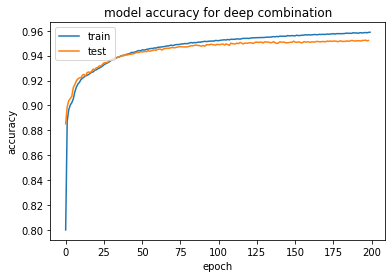

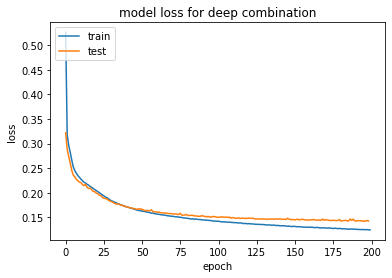

In [33]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_combine.history['acc'])
plt.plot(history_combine.history['val_acc'])
plt.title('model accuracy for deep combination')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Plots/accuracy_deepCombine.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_combine.history['loss'])
plt.plot(history_combine.history['val_loss'])
plt.title('model loss for deep combination')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Plots/loss_deepCombine.pdf')
plt.show()


In [24]:
y_combine_pred = model_combine.predict([x_flat_te[0], x_flat_te[1], x_flat_te[2], x_flat_te[3], x_flat_te[4], x_flat_te[5]])
fpr_combine, tpr_combine, thres_combine = roc_curve(y_flat_te_onehot[layer_i][:,1], y_combine_pred[:,1])
auc_combine = auc(fpr_combine, tpr_combine)
print("Area under curve: {}".format(auc_combine))

Area under curve: 0.985854843117698


<Figure size 432x288 with 0 Axes>

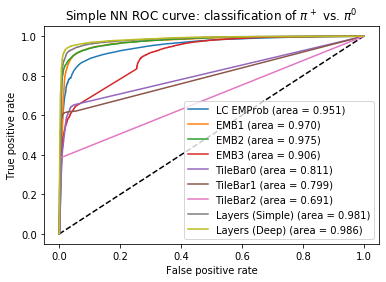

<Figure size 432x288 with 0 Axes>

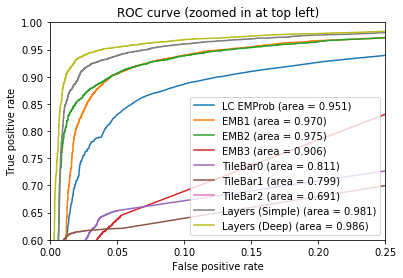

In [35]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_combine2_layers.pdf')
plt.show()


plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
# Zoom in view of the upper left corner.
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_combine2_layers.pdf')
plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


<Figure size 432x288 with 0 Axes>

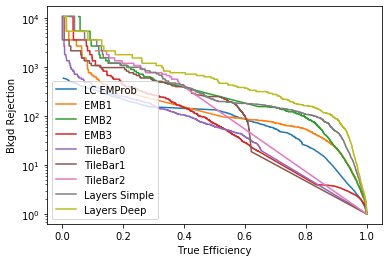

In [32]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.yscale('log')
plt.plot(tpr_lc, 1/fpr_lc, label='LC EMProb')
for layer_i, layer_name in enumerate(layers):
    plt.plot(tpr_flat_nn[layer_i], 1/fpr_flat_nn[layer_i], label='{}'.format(layer_name))
plt.plot(tpr_simpleCombine, 1/fpr_simpleCombine, label='Layers Simple')
plt.plot(tpr_combine, 1/fpr_combine, label='Layers Deep')
plt.legend(loc='best')
plt.xlabel('True Efficiency')
plt.ylabel('Bkgd Rejection')
plt.savefig(plotpath+'roc_reg_combine2_layers.pdf')
plt.show()


In [36]:
#function to split apart a prediction list according to the one hot values.
#really, could have done this by evaluating the nn with a non-concatted nparray, but we already have this handy
def split_pred(onehot, pred):
    list_one = [element_n for element_n, element in enumerate(onehot) if element==1]
    one_vals = [element for element_n, element in enumerate(pred) if element_n in list_one]
    zer_vals = [element for element_n, element in enumerate(pred) if element_n not in list_one]
    
    return one_vals, zer_vals

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


<Figure size 432x288 with 0 Axes>

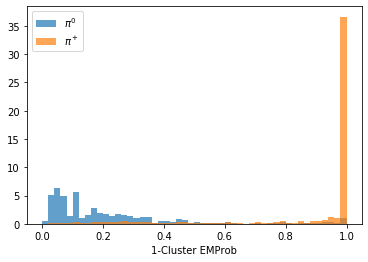

In [ ]:
n_bins = 50
#time for histogramming
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(1-p0['cluster_EM_PROBABILITY'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
plt.hist(1-pp['cluster_EM_PROBABILITY'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('1-Cluster EMProb')
plt.legend()
plt.savefig('Plots/hist_emprob.pdf')
plt.show()

pip_vals_combine, p0_vals_combine = split_pred(y_flat_te_onehot[layer_i][:,1], y_combine_pred[:,1])

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(p0_vals_combine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
plt.hist(pip_vals_combine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('Deep Combined NN')
plt.legend()
plt.savefig('Plots/hist_deep.pdf')
plt.show()

pip_vals_simpleCombine, p0_vals_simpleCombine = split_pred(y_flat_vl_onehot[layer_i][:,1], combined_pred[:,1])
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(p0_vals_simpleCombine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
plt.hist(pip_vals_simpleCombine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('Simple Combined NN')
plt.legend()
plt.savefig('Plots/hist_simple.pdf')
plt.show()

pip_vals_flat = {}
p0_vals_flat = {}
for layer_i, layer_name in enumerate(layers):
    plt.cla(); plt.clf()
    pip_vals_flat[layer_i], p0_vals_flat[layer_i] = split_pred(y_flat_te_onehot[layer_i][:,1], y_flat_pred[layer_i][:,1])
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist(p0_vals_flat[layer_i], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
    plt.hist(pip_vals_flat[layer_i], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
    plt.xlabel('{} Flat NN'.format(layer_name))
    plt.legend()
    plt.savefig('Plots/hist_flatnn_{}.pdf'.format(layer_name))
    plt.show()

## 2. Convolutional Neural Network

In [33]:
def format_cnn(data_0, data_1, selected_layer, len_phi = len_phi, len_eta = len_eta):
    layer = layers[selected_layer]
    num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])
    X = np.append(data_0[layer], data_1[layer], axis=0)
    X = X.reshape(X.shape[0], 1, len_phi[selected_layer], len_eta[selected_layer])
    
    Y = np.append(data_0['label'], data_1['label'], axis=0)
    return X, Y, num_pixels

In [37]:

#old, one by one method
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_data_format('channels_first')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Train on pT = 100 GeV electron/pion samples
# mswiatlo-- let's do this with the pi+/pi0 samples!

# include the EMB2 layer as a 2D image
selected_layer = 1
layer = layers[selected_layer]
num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])

# X = np.append(elec[layer], pion[layer], axis=0)
X = np.append(pp[layer], p0[layer], axis=0)
# reshape to be [samples][width][height][pixels]
#X = X.reshape(X.shape[0], 1, 128, 4)
X = X.reshape(X.shape[0], 1, 16, 16)

# y = np.append(elec['label'], pion['label'], axis=0)
y = np.append(pp['label'], p0['label'], axis=0)

# split up into training and test datasets
test_size = 4000
validation_size = 1000
from sklearn.model_selection import train_test_split
X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

print (X_tr.shape)
print (y_tr.shape)

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr, 2)
y_te_onehot = np_utils.to_categorical(y_te, 2)
y_vl_onehot = np_utils.to_categorical(y_vl, 2)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

(468521, 1, 16, 16)
(468521, 1)
y_train.shape:  (468521, 1)
y_train_onehot.shape:  (468521, 2)


In [36]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.utils import np_utils
from tensorflow.keras import backend as K
# K.image_data_format('th')
K.set_image_data_format('channels_first')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

x_cnn = {}
y_cnn = {}
num_pixels_cnn = {}
for layer_i, layer_name in enumerate(layers):
    x_cnn[layer_i], y_cnn[layer_i], num_pixels_cnn[layer_i] = format_cnn(p0, pp, layer_i)

In [37]:
# split up into training and test datasets, using functions
test_size = 24000
validation_size = 24000

x_cnn_tr = {}
x_cnn_te = {}
x_cnn_vl = {}
y_cnn_tr_onehot = {}
y_cnn_te_onehot = {}
y_cnn_vl_onehot = {}
for layer_i, layer_name in enumerate(layers):
    x_cnn_tr[layer_i], x_cnn_te[layer_i], x_cnn_vl[layer_i], y_cnn_tr_onehot[layer_i], y_cnn_te_onehot[layer_i], y_cnn_vl_onehot[layer_i] = make_split_samples(x_cnn[layer_i], y_cnn[layer_i], test_size, validation_size)


y_train.shape:  (425521, 1)
y_train_onehot.shape:  (425521, 2)
y_train.shape:  (425521, 1)
y_train_onehot.shape:  (425521, 2)
y_train.shape:  (425521, 1)
y_train_onehot.shape:  (425521, 2)
y_train.shape:  (425521, 1)
y_train_onehot.shape:  (425521, 2)
y_train.shape:  (425521, 1)
y_train_onehot.shape:  (425521, 2)
y_train.shape:  (425521, 1)
y_train_onehot.shape:  (425521, 2)


In [140]:
# define a simple convolutional model
def baseline_ccn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), input_shape=(1,16,16), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [38]:
# define a simple convolutional model

filters = [(2,4), (4,4), (4,4), (2,2), (2,2), (2,1)]

def baseline_cnn_model_layers(layer_i):
    # create model
    with strategy.scope():
        model = Sequential()
        model.add(Conv2D(32, filters[layer_i], input_shape=(1,len_phi[layer_i],len_eta[layer_i]), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model

In [39]:
model_cnn_base_layers = {}
for layer_i, layer_name in enumerate(layers):
    print(layer_name)
    print(len_phi[layer_i])
    print(len_eta[layer_i])
    model_cnn_base_layers[layer_i] = baseline_cnn_model_layers(layer_i)
    model_cnn_base_layers[layer_i].summary()

EMB1
4
128
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 3, 125)        288       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 1, 62)         0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 32, 1, 62)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1984)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               254080    
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 258       
Total params: 254,626
Trainable params: 254,626
Non-trainable params: 0
_____________________________________

In [83]:
# define a deep-ish convolutional model
def larger_cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), input_shape=(1,16,16), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [84]:
# build the model
model_cnn_large = larger_cnn_model()
model_cnn_large.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 13, 13)        544       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 6, 6)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 5, 5)          2064      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 2, 2)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 2, 2)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 128)             

In [ ]:
history_cnn_base_layers = {}
for layer_i, layer_name in enumerate(layers):
    print('On layer {}'.format(layer_name))
    history_cnn_base_layers[layer_i] = model_cnn_base_layers[layer_i].fit(x_cnn_tr[layer_i], y_cnn_tr_onehot[layer_i], validation_data=(x_cnn_vl[layer_i], y_cnn_vl_onehot[layer_i]), epochs=200, batch_size=200*ngpu, verbose=2)


On layer EMB1
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl,num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
Epoch 1/200
532/532 - 21s - loss: 0.4526 - acc: 0.8068 - val_loss: 0.3961 - val_acc: 0.8366
Epoch 2/200
532/532 - 5s - loss: 0.3891 - acc: 0.8409 - val_loss: 0.3889 - val_acc: 0.8419
Epoch 3/200
532/532 - 5s - loss: 0.3822 - acc: 0.8455 - val_loss: 0.3820 - val_acc: 0.8454
Epoch 4/200
532/532 - 5s - loss: 0.3736 - acc: 0.8505 - val_loss: 0.3726 - val_acc: 0.8527
Epoch 5/200
532/532 - 5s - loss: 0.3624 - acc: 0.8558 - val_loss: 0.3595 - val_acc: 0.8595
Epoch 6/200
532/532 - 5s - loss: 0.3527 - acc: 0.8607 - val_loss: 0.3549 - val_acc: 0.8613
Epoch 7/200
532/532 - 5s - loss: 0.3452 - acc: 0.8648 - val_loss: 0.3434 - val_acc: 0.8668
Epoch 8/200
532/532 - 5s - loss: 0.3405 - acc: 0.8676 - val_loss: 0.3394 - val_acc: 0.8692
Epoch 9/200
532/532 - 5s - loss: 0.3355 - acc: 0.8696 - val_loss: 0.3359 - val_acc: 0.8698
Epoch 10/200
532

Epoch 89/200
532/532 - 5s - loss: 0.2693 - acc: 0.8968 - val_loss: 0.2799 - val_acc: 0.8956
Epoch 90/200
532/532 - 5s - loss: 0.2674 - acc: 0.8977 - val_loss: 0.2785 - val_acc: 0.8949
Epoch 91/200
532/532 - 5s - loss: 0.2682 - acc: 0.8974 - val_loss: 0.2797 - val_acc: 0.8943
Epoch 92/200
532/532 - 5s - loss: 0.2685 - acc: 0.8972 - val_loss: 0.2821 - val_acc: 0.8938
Epoch 93/200
532/532 - 5s - loss: 0.2678 - acc: 0.8976 - val_loss: 0.2779 - val_acc: 0.8962
Epoch 94/200
532/532 - 5s - loss: 0.2681 - acc: 0.8976 - val_loss: 0.2826 - val_acc: 0.8959
Epoch 95/200
532/532 - 5s - loss: 0.2667 - acc: 0.8978 - val_loss: 0.2777 - val_acc: 0.8950
Epoch 96/200
532/532 - 5s - loss: 0.2676 - acc: 0.8978 - val_loss: 0.2784 - val_acc: 0.8949
Epoch 97/200
532/532 - 5s - loss: 0.2674 - acc: 0.8978 - val_loss: 0.2800 - val_acc: 0.8935
Epoch 98/200
532/532 - 5s - loss: 0.2666 - acc: 0.8981 - val_loss: 0.2786 - val_acc: 0.8954
Epoch 99/200
532/532 - 5s - loss: 0.2661 - acc: 0.8980 - val_loss: 0.2816 - val_

Epoch 178/200
532/532 - 6s - loss: 0.2557 - acc: 0.9029 - val_loss: 0.2784 - val_acc: 0.8960
Epoch 179/200
532/532 - 6s - loss: 0.2543 - acc: 0.9029 - val_loss: 0.2739 - val_acc: 0.8980
Epoch 180/200
532/532 - 6s - loss: 0.2549 - acc: 0.9028 - val_loss: 0.2737 - val_acc: 0.8993
Epoch 181/200
532/532 - 5s - loss: 0.2553 - acc: 0.9025 - val_loss: 0.2758 - val_acc: 0.8978
Epoch 182/200
532/532 - 5s - loss: 0.2544 - acc: 0.9030 - val_loss: 0.2742 - val_acc: 0.8988
Epoch 183/200
532/532 - 6s - loss: 0.2548 - acc: 0.9027 - val_loss: 0.2751 - val_acc: 0.8990
Epoch 184/200
532/532 - 6s - loss: 0.2557 - acc: 0.9025 - val_loss: 0.2783 - val_acc: 0.8964
Epoch 185/200
532/532 - 6s - loss: 0.2547 - acc: 0.9029 - val_loss: 0.2759 - val_acc: 0.8975
Epoch 186/200
532/532 - 6s - loss: 0.2546 - acc: 0.9030 - val_loss: 0.2782 - val_acc: 0.8977
Epoch 187/200
532/532 - 5s - loss: 0.2544 - acc: 0.9028 - val_loss: 0.2733 - val_acc: 0.8984
Epoch 188/200
532/532 - 6s - loss: 0.2545 - acc: 0.9027 - val_loss: 0.

Epoch 64/200
532/532 - 6s - loss: 0.2500 - acc: 0.8990 - val_loss: 0.2540 - val_acc: 0.8969
Epoch 65/200
532/532 - 5s - loss: 0.2502 - acc: 0.8990 - val_loss: 0.2530 - val_acc: 0.8976
Epoch 66/200
532/532 - 6s - loss: 0.2496 - acc: 0.8990 - val_loss: 0.2521 - val_acc: 0.8982
Epoch 67/200
532/532 - 5s - loss: 0.2494 - acc: 0.8992 - val_loss: 0.2576 - val_acc: 0.8961
Epoch 68/200
532/532 - 5s - loss: 0.2493 - acc: 0.8992 - val_loss: 0.2524 - val_acc: 0.8988
Epoch 69/200
532/532 - 5s - loss: 0.2483 - acc: 0.8997 - val_loss: 0.2534 - val_acc: 0.8968
Epoch 70/200
532/532 - 5s - loss: 0.2489 - acc: 0.8997 - val_loss: 0.2507 - val_acc: 0.8984
Epoch 71/200
532/532 - 6s - loss: 0.2484 - acc: 0.9001 - val_loss: 0.2516 - val_acc: 0.8985
Epoch 72/200
532/532 - 6s - loss: 0.2486 - acc: 0.8998 - val_loss: 0.2518 - val_acc: 0.8992
Epoch 73/200
532/532 - 6s - loss: 0.2480 - acc: 0.8996 - val_loss: 0.2502 - val_acc: 0.8982
Epoch 74/200
532/532 - 5s - loss: 0.2477 - acc: 0.9001 - val_loss: 0.2502 - val_

Epoch 153/200
532/532 - 5s - loss: 0.2361 - acc: 0.9054 - val_loss: 0.2464 - val_acc: 0.9025
Epoch 154/200
532/532 - 6s - loss: 0.2364 - acc: 0.9050 - val_loss: 0.2474 - val_acc: 0.9017
Epoch 155/200
532/532 - 6s - loss: 0.2364 - acc: 0.9052 - val_loss: 0.2485 - val_acc: 0.9013
Epoch 156/200
532/532 - 5s - loss: 0.2365 - acc: 0.9052 - val_loss: 0.2475 - val_acc: 0.9025
Epoch 157/200
532/532 - 6s - loss: 0.2360 - acc: 0.9050 - val_loss: 0.2480 - val_acc: 0.9016
Epoch 158/200
532/532 - 5s - loss: 0.2364 - acc: 0.9053 - val_loss: 0.2472 - val_acc: 0.9033
Epoch 159/200
532/532 - 5s - loss: 0.2360 - acc: 0.9053 - val_loss: 0.2473 - val_acc: 0.9020
Epoch 160/200
532/532 - 6s - loss: 0.2358 - acc: 0.9055 - val_loss: 0.2472 - val_acc: 0.9017
Epoch 161/200
532/532 - 6s - loss: 0.2356 - acc: 0.9057 - val_loss: 0.2471 - val_acc: 0.9016
Epoch 162/200
532/532 - 6s - loss: 0.2354 - acc: 0.9057 - val_loss: 0.2478 - val_acc: 0.9010
Epoch 163/200
532/532 - 5s - loss: 0.2363 - acc: 0.9057 - val_loss: 0.

<Figure size 432x288 with 0 Axes>

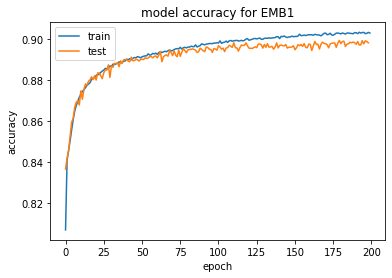

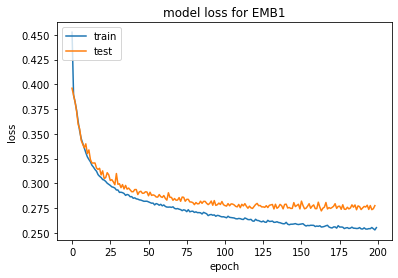

<Figure size 432x288 with 0 Axes>

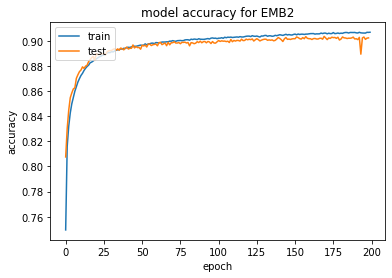

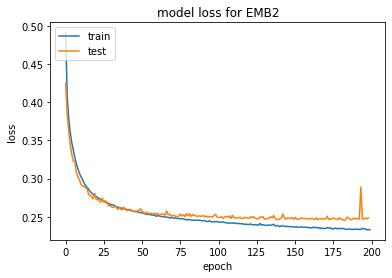

<Figure size 432x288 with 0 Axes>

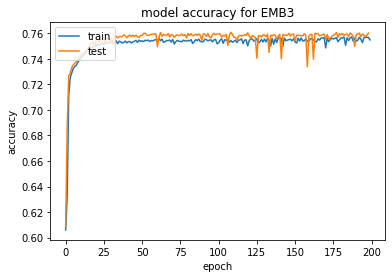

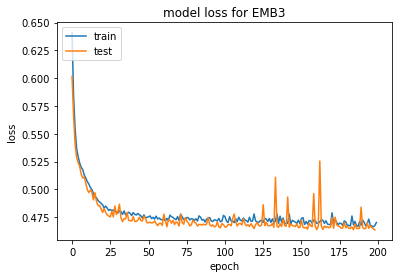

<Figure size 432x288 with 0 Axes>

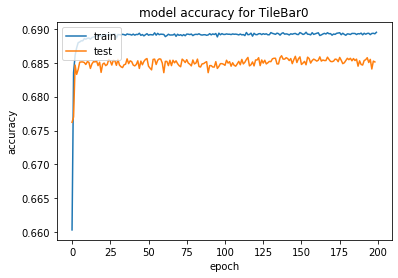

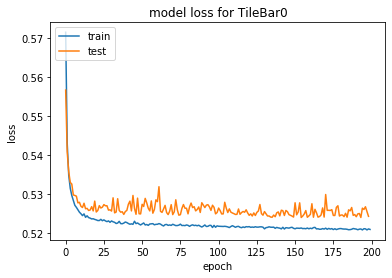

<Figure size 432x288 with 0 Axes>

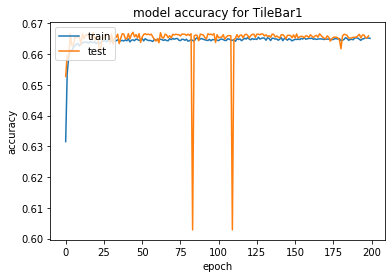

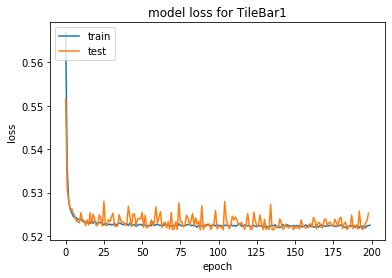

<Figure size 432x288 with 0 Axes>

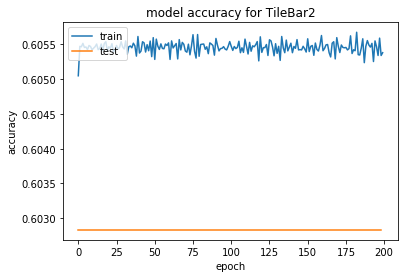

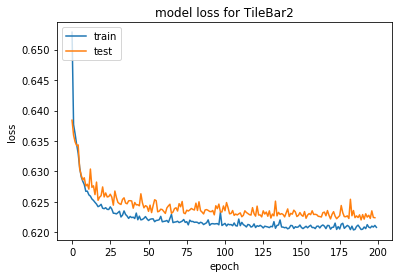

In [42]:
for layer_i, layer_name in enumerate(layers):
#     print(history_flat[layer_i].history.keys())
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_cnn_base_layers[layer_i].history['acc'])
    plt.plot(history_cnn_base_layers[layer_i].history['val_acc'])
    plt.title('model accuracy for {}'.format(layer_name))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/accuracy_cnn_{}.pdf'.format(layer_name))
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_cnn_base_layers[layer_i].history['loss'])
    plt.plot(history_cnn_base_layers[layer_i].history['val_loss'])
    plt.title('model loss for {}'.format(layer_name))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/loss_cnn_{}.pdf'.format(layer_name))
    plt.show()

In [89]:
# fit (train) the larger cnn model
history_cnn_large = model_cnn_large.fit(X_tr, y_tr_onehot, validation_data=(X_vl, y_vl_onehot), epochs=40, batch_size=200, verbose=2)

# final evaluation of the model
scores_cnn_large = model_cnn_large.evaluate(X_te, y_te_onehot, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores_cnn_large[1]*100))

Train on 95000 samples, validate on 1000 samples
Epoch 1/40
 - 4s - loss: 0.3903 - accuracy: 0.8342 - val_loss: 0.3721 - val_accuracy: 0.8350
Epoch 2/40
 - 4s - loss: 0.3795 - accuracy: 0.8409 - val_loss: 0.3659 - val_accuracy: 0.8410
Epoch 3/40
 - 4s - loss: 0.3722 - accuracy: 0.8450 - val_loss: 0.3510 - val_accuracy: 0.8450
Epoch 4/40
 - 4s - loss: 0.3658 - accuracy: 0.8493 - val_loss: 0.3433 - val_accuracy: 0.8570
Epoch 5/40
 - 4s - loss: 0.3605 - accuracy: 0.8518 - val_loss: 0.3316 - val_accuracy: 0.8650
Epoch 6/40
 - 4s - loss: 0.3554 - accuracy: 0.8547 - val_loss: 0.3519 - val_accuracy: 0.8610
Epoch 7/40
 - 4s - loss: 0.3498 - accuracy: 0.8566 - val_loss: 0.3289 - val_accuracy: 0.8680
Epoch 8/40
 - 4s - loss: 0.3460 - accuracy: 0.8589 - val_loss: 0.3266 - val_accuracy: 0.8680
Epoch 9/40
 - 4s - loss: 0.3442 - accuracy: 0.8607 - val_loss: 0.3234 - val_accuracy: 0.8690
Epoch 10/40
 - 4s - loss: 0.3394 - accuracy: 0.8616 - val_loss: 0.3170 - val_accuracy: 0.8620
Epoch 11/40
 - 4s - 

In [90]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history_cnn_large.history.keys())
fig = plt.figure()
fig.patch.set_facecolor('white')

# summarize history for accuracy
plt.plot(history_cnn_large.history['acc'])
plt.plot(history_cnn_large.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_cnn_large.history['loss'])
plt.plot(history_cnn_large.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


KeyError: 'acc'

<Figure size 432x288 with 0 Axes>

In [93]:
y_baseline_pred = model_cnn_base.predict(X_te)
fpr_baseline, tpr_baseline, thres_baseline = roc_curve(y_te_onehot[:,1], y_baseline_pred[:,1])
auc_baseline = auc(fpr_baseline, tpr_baseline)
print("Area under curve: {}".format(auc_baseline))

y_large_pred = model_cnn_large.predict(X_te)
fpr_large, tpr_large, thres_large = roc_curve(y_te_onehot[:,1], y_large_pred[:,1])
auc_large = auc(fpr_large, tpr_large)
print("Area under curve: {}".format(auc_large))

Area under curve: 0.9482839437465216
Area under curve: 0.9426352090745941


In [43]:
y_baseline_layers_pred = {}
fpr_baseline_layers = {}
tpr_baseline_layers = {}
thres_baseline_layers = {}
auc_baseline_layers = {}
for layer_i, layer_name in enumerate(layers):
    y_baseline_layers_pred[layer_i] = model_cnn_base_layers[layer_i].predict(x_cnn_te[layer_i])
    fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i], thres_baseline_layers[layer_i] = roc_curve(y_cnn_te_onehot[layer_i][:,1], y_baseline_layers_pred[layer_i][:,1])
    auc_baseline_layers[layer_i] = auc(fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i])
    print("Area under curve: {}".format(auc_baseline_layers[layer_i]))
#     y_flat_pred[layer_i] = models_flat[layer_i].predict(x_flat_te[layer_i])
#     fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], thres_flat_nn[layer_i] = roc_curve(y_flat_te_onehot[layer_i][:,1], y_flat_pred[layer_i][:,1])
#     auc_flat_nn[layer_i] = auc(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i])
#     print("Area under curve: {}".format(auc_flat_nn[layer_i]))


Area under curve: 0.9486574076350677
Area under curve: 0.9605159508756631
Area under curve: 0.8230046229591856
Area under curve: 0.736457505219338
Area under curve: 0.7264892410519067
Area under curve: 0.586519029934403


In [45]:
for layer_i, layer_name in enumerate(layers):
    print('Saving {}'.format(layer_name))
    model_cnn_base_layers[layer_i].save(modelpath+"model_{}_cnn_base.h5".format(layer_name))

Saving EMB1
Saving EMB2
Saving EMB3
Saving TileBar0
Saving TileBar1
Saving TileBar2


<Figure size 432x288 with 0 Axes>

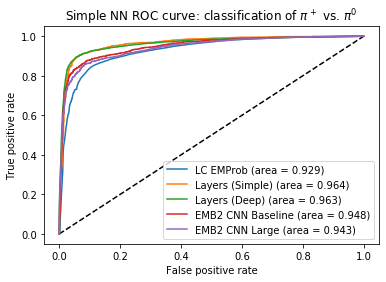

<Figure size 432x288 with 0 Axes>

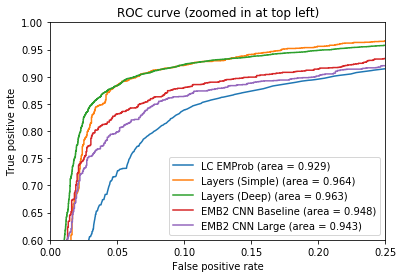

In [94]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
plt.plot(fpr_baseline, tpr_baseline, label='{} (area = {:.3f})'.format("EMB2 CNN Baseline", auc_baseline))
plt.plot(fpr_large, tpr_large, label='{} (area = {:.3f})'.format("EMB2 CNN Large", auc_large))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_combine2_cnn.pdf')
plt.show()


plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
# Zoom in view of the upper left corner.
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
plt.plot(fpr_baseline, tpr_baseline, label='{} (area = {:.3f})'.format("EMB2 CNN Baseline", auc_baseline))
plt.plot(fpr_large, tpr_large, label='{} (area = {:.3f})'.format("EMB2 CNN Large", auc_large))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_combine2_cnn.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

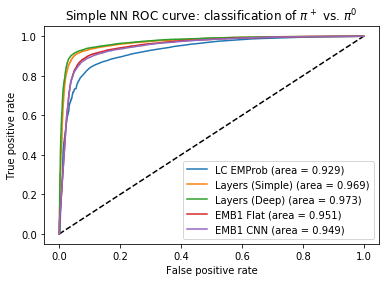

<Figure size 432x288 with 0 Axes>

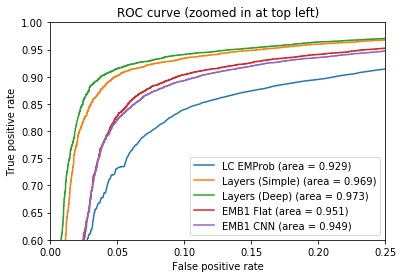

<Figure size 432x288 with 0 Axes>

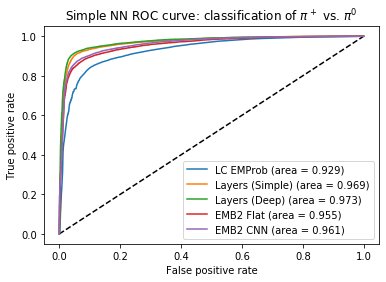

<Figure size 432x288 with 0 Axes>

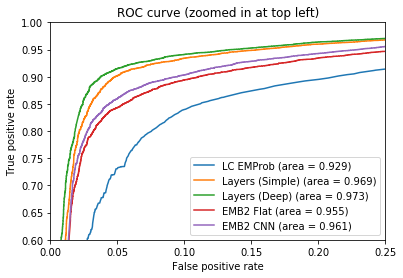

<Figure size 432x288 with 0 Axes>

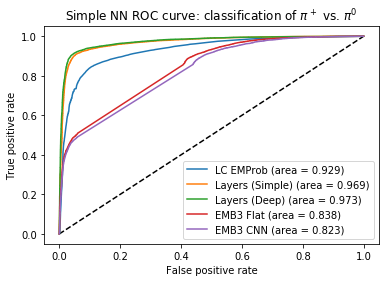

<Figure size 432x288 with 0 Axes>

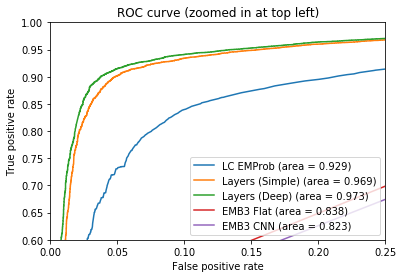

<Figure size 432x288 with 0 Axes>

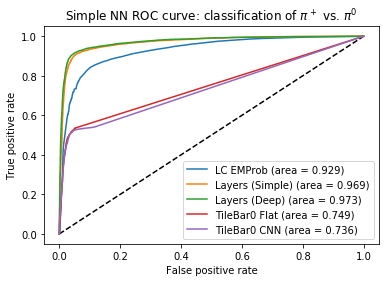

<Figure size 432x288 with 0 Axes>

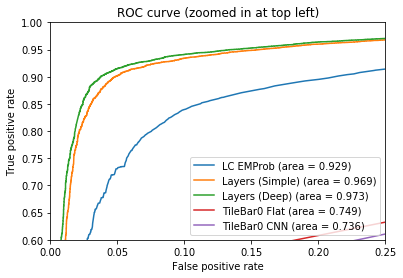

<Figure size 432x288 with 0 Axes>

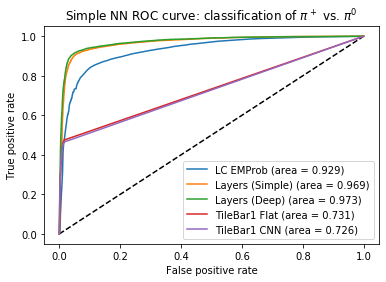

<Figure size 432x288 with 0 Axes>

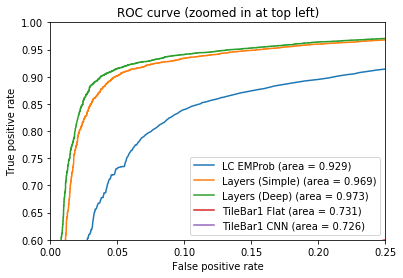

<Figure size 432x288 with 0 Axes>

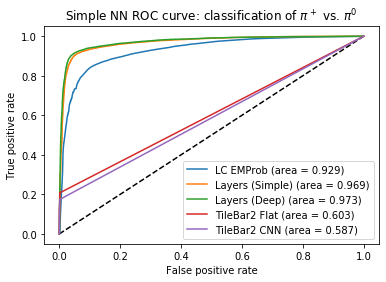

<Figure size 432x288 with 0 Axes>

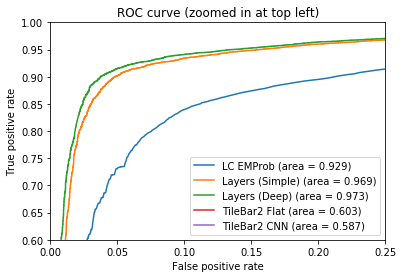

In [44]:
for layer_i, layer_name in enumerate(layers):
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
    plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
    plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} Flat (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
    plt.plot(fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i], label='{} CNN (area = {:.3f})'.format(layer_name, auc_baseline_layers[layer_i]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
    plt.legend(loc='best')
    plt.savefig('Plots/roc_layers_cnn_{}.pdf'.format(layer_name))
    plt.show()


    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    # Zoom in view of the upper left corner.
    plt.xlim(0, 0.25)
    plt.ylim(0.6, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
    plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
    plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} Flat (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
    plt.plot(fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i], label='{} CNN (area = {:.3f})'.format(layer_name, auc_baseline_layers[layer_i]))
    # ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (zoomed in at top left)')
    plt.legend(loc='best')
    plt.savefig('Plots/roc_zoom_layers_cnn_{}.pdf'.format(layer_name))
    plt.show()

## 3. Train multiple ConvNets on the images and merge

Next, try to train convolutional nets on multiple input layers, then merge and flatten the layers.

In [ ]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Train on pT = 100 GeV electron/pion samples
# Mswiatlo-- let's do it on pi+ vs pi0

# This will allow it to be images, instead of flatenned, in emb1
# X0 = np.append(pp['EMB1'], p0['EMB1'], axis=0)

# flatten first layer (for now...) 
X0 = np.append(pp['EMB1'].reshape((len(pp['EMB1']),512)),
              p0['EMB1'].reshape((len(p0['EMB1']),512)), axis=0)

X1 = np.append(pp['EMB2'], p0['EMB2'], axis=0)
X2 = np.append(pp['EMB3'], p0['EMB3'], axis=0)

# reshape to be [samples][width][height][pixels]
# X0 = X0.reshape(X0.shape[0], 1, 128, 4) #uncomment for images mode
X1 = X1.reshape(X1.shape[0], 1, 16, 16)
X2 = X2.reshape(X2.shape[0], 1, 8, 16)

y = np.append(pp['label'], p0['label'], axis=0)

print X0.shape
print X1.shape
print X2.shape
print y.shape

# split up into training and test datasets
# test_size = 4000
# validation_size = 1000
test_size = 8000 # double this, mswiatlo
validation_size = 2000 #double this, mswiatlo
from sklearn.model_selection import train_test_split
X0_tr, X0_te_vl, X1_tr, X1_te_vl, X2_tr, X2_te_vl, y_tr, y_te_vl, = train_test_split(X0, X1, X2, y, test_size=test_size+validation_size, random_state=1)
X0_te, X0_vl, X1_te, X1_vl, X2_te, X2_vl, y_te, y_vl, = train_test_split(X0_te_vl, X1_te_vl, X2_te_vl, y_te_vl, test_size=validation_size, random_state=1)

# normalize inputs from 0-255 to 0-1
X0_tr = X0_tr / 255
X0_te = X0_te / 255
X0_vl = X0_vl / 255
X1_tr = X1_tr / 255
X1_te = X1_te / 255
X1_vl = X1_vl / 255
X2_tr = X2_tr / 255
X2_te = X2_te / 255
X2_vl = X2_vl / 255

print (X0_tr.shape)
print (y_tr.shape)

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr, 2)
y_te_onehot = np_utils.to_categorical(y_te, 2)
y_vl_onehot = np_utils.to_categorical(y_vl, 2)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

In [ ]:
# define convolutional model for multiple input images

from keras.models import Model
from keras.layers import concatenate
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [ ]:
# create model

def merged_model_emb12():
    
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(512,), name='input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dense(256, activation='relu')(x1) 
    x1 = Dense(128, activation='relu')(x1) 

    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu')(input2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)

    # concatenate outputs from the two networks above
    x = concatenate([x1, x2]) 
    x = Dense(50, activation='relu')(x)    

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2], outputs = [output])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

In [ ]:
# build the model
model_merged_emb12 = merged_model_emb12()
model_merged_emb12.summary()

In [ ]:
# fit (train) the merged model
history = model_merged_emb12.fit([X0_tr, X1_tr], [y_tr_onehot], validation_data=([X0_vl, X1_vl], [y_vl_onehot]), epochs=80, batch_size=200, verbose=2)

# final evaluation of the model
scores = model_merged_emb12.evaluate([X0_te, X1_te], [y_te_onehot], verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history.history.keys())

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.savefig('merged_cnn_accuracy.pdf')

# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
#plt.savefig('merged_cnn_loss.pdf')

In [ ]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_merged_emb12.predict([X0_te, X1_te])
fpr_merge_emb12, tpr_merge_emb12, thres_merge = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_merge = auc(fpr_merge_emb12, tpr_merge_emb12)
print("Area under curve: {}".format(auc_merge))

In [ ]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.patch.set_facecolor('white')
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[0].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2ConvNet (area = {:.3f})'.format(auc_merge))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve: classification of pi0 (vs. charged pions)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(0.8, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2 ConvNet (area = {:.3f})'.format(auc_merge))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()
#plt.savefig('ROC_curve_final.pdf')

Next: Include all input images (calorimeter layers)

Visualize the filters: 
 https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59

In [ ]:
# create model

def merged_model_emb123():
    
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(512,), name='input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dense(256, activation='relu')(x1) 
    x1 = Dense(128, activation='relu')(x1) 

    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu')(input2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    
    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu')(input3)
    x3 = MaxPooling2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3]) 
    x = Dense(50, activation='relu')(x)    

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3], outputs = [output])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

In [ ]:
model_merged_emb123 = merged_model_emb123()
model_merged_emb123.summary()

In [ ]:
# fit (train) the merged model
history_emb123 = model_merged_emb123.fit([X0_tr, X1_tr, X2_tr], [y_tr_onehot], validation_data=([X0_vl, X1_vl, X2_vl], [y_vl_onehot]), epochs=80, batch_size=200, verbose=2)

# final evaluation of the model
scores_emb123 = model_merged_emb123.evaluate([X0_te, X1_te, X2_te], [y_te_onehot], verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_merged_emb123.predict([X0_te, X1_te, X2_te])
fpr_merge_emb123, tpr_merge_emb123, thres_merge = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_merge_emb123 = auc(fpr_merge_emb123, tpr_merge_emb123)
print("Area under curve: {}".format(auc_merge_emb123))

In [ ]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.patch.set_facecolor('white')
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[0].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2ConvNet (area = {:.3f})'.format(auc_merge))
ax[0].plot(fpr_merge_emb123, tpr_merge_emb123, label='Merged EMB1f + EMB2ConvNet +EMB3ConvNet (area = {:.3f})'.format(auc_merge_emb123))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve: classification of pi0 (vs. charged pions)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(0.8, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2 ConvNet (area = {:.3f})'.format(auc_merge))
ax[1].plot(fpr_merge_emb123, tpr_merge_emb123, label='Merged EMB1f + EMB2ConvNet +EMB3ConvNet (area = {:.3f})'.format(auc_merge_emb123))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()
#plt.savefig('ROC_curve_final.pdf')